# Python 中实现四叉树生成

本实验不参考教材 7.3 节。我横竖没看懂。不如自己去看个教程写出来。

本实验参考这个：[Quad Tree - GeeksForGeeks](https://www.geeksforgeeks.org/dsa/quad-tree/)

关于 Quad Tree and Morton Code 还真没找到什么好资料，因此这部分还是请教了 Perplexity 大人。

In [1]:
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np

@dataclass(frozen=True)
class QuadLeaf:
    # 叶子矩形在原始grid中的范围：行列索引（上、下、左、右，右下边界为开区间）
    r0: int
    c0: int
    r1: int
    c1: int
    value: int  # 该块的统一栅格值
    code4: str  # 四进制编码（如 "0123"）
    morton: int # 莫顿码（十进制）


def is_uniform(block: np.ndarray) -> Optional[int]:
    """若block所有元素相同，返回该值，否则返回None"""
    first = block.flat[0]
    if np.all(block == first):
        return int(first)
    return None


def subdivide(r0: int, r1: int, c0: int, c1: int) -> List[Tuple[int,int,int,int]]:
    """将矩形范围划分为四个子象限（0:左上,1:右上,2:左下,3:右下）"""
    rm = (r0 + r1) // 2
    cm = (c0 + c1) // 2
    return [
        (r0, rm, c0, cm),  # 0 左上
        (r0, rm, cm, c1),  # 1 右上
        (rm, r1, c0, cm),  # 2 左下
        (rm, r1, cm, c1),  # 3 右下
    ]


def morton_encode(code4: str) -> int:
    """将四进制字符串解释为基数为4的数字，返回十进制莫顿码。"""
    val = 0
    for ch in code4:
        val = val * 4 + int(ch)
    return val


def build_quadtree(grid: np.ndarray) -> List[QuadLeaf]:
    """自上而下构建四叉树：对非一致块递归分割，生成叶子结点列表。"""
    H, W = grid.shape
    leaves: List[QuadLeaf] = []

    def dfs(r0: int, r1: int, c0: int, c1: int, code4: str):
        block = grid[r0:r1, c0:c1]
        uni = is_uniform(block)
        if uni is not None:
            leaves.append(QuadLeaf(r0, c0, r1, c1, uni, code4, morton_encode(code4)))
            return
        # 非一致则继续分割
        for i, (sr0, sr1, sc0, sc1) in enumerate(subdivide(r0, r1, c0, c1)):
            dfs(sr0, sr1, sc0, sc1, code4 + str(i))

    dfs(0, H, 0, W, "")
    return leaves


def point_to_code(row: int, col: int, H: int, W: int) -> str:
    """给定像素(row,col)，计算其走过的四进制象限路径。"""
    r0, r1, c0, c1 = 0, H, 0, W
    code = ""
    while r1 - r0 > 1 or c1 - c0 > 1:
        rm = (r0 + r1) // 2
        cm = (c0 + c1) // 2
        if row < rm and col < cm:
            code += "0"; r1, c1 = rm, cm
        elif row < rm and col >= cm:
            code += "1"; r1, c0 = rm, cm
        elif row >= rm and col < cm:
            code += "2"; r0, c1 = rm, cm
        else:
            code += "3"; r0, c0 = rm, cm
        if r1 - r0 == 0 or c1 - c0 == 0:
            break
    return code


def query_mapping(leaves: List[QuadLeaf], row: int, col: int) -> Dict[str, int]:
    """输入栅格位置，返回四进制-十进制-栅格值映射。"""
    for leaf in leaves:
        if leaf.r0 <= row < leaf.r1 and leaf.c0 <= col < leaf.c1:
            return {"code4": leaf.code4, "morton": leaf.morton, "value": leaf.value}
    # 若没有命中（不应该发生），返回直接像素编码
    H = max(l.r1 for l in leaves)
    W = max(l.c1 for l in leaves)
    code4 = point_to_code(row, col, H, W)
    return {"code4": code4, "morton": morton_encode(code4), "value": int(grid[row, col])}

# 示例栅格
grid = np.array([
    [1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
    [1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
    [1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
    [1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
    [5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8],
    [5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8],
    [5, 5, 1, 1, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8],
    [5, 5, 1, 1, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8],
    [9, 9, 1, 1, 5, 5, 6, 6, 2, 2, 3, 3, 4, 4, 5, 5],
    [9, 9, 1, 1, 5, 5, 6, 6, 2, 2, 3, 3, 4, 4, 5, 5],
    [9, 9, 5, 5, 5, 5, 6, 6, 2, 2, 3, 3, 4, 4, 5, 5],
    [9, 9, 5, 5, 5, 5, 6, 6, 2, 2, 3, 3, 4, 1, 5, 5],
    [6, 6, 6, 5, 7, 7, 7, 7, 8, 8, 8, 8, 1, 1, 1, 3],
    [6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 1, 1, 1, 1],
    [6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 1, 1, 2, 2],
    [6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 1, 1, 2, 2],
])

# 构建四叉树并输出叶子列表
leaves = build_quadtree(grid)
print(f"叶子结点数量: {len(leaves)}")
print("示例前10个叶子：")
for i, lf in enumerate(leaves[:10]):
    print(i, (lf.r0, lf.c0, lf.r1, lf.c1), lf.value, lf.code4, lf.morton)

叶子结点数量: 52
示例前10个叶子：
0 (0, 0, 4, 4) 1 00 0
1 (0, 4, 2, 6) 1 010 4
2 (0, 6, 2, 8) 2 011 5
3 (2, 4, 4, 6) 1 012 6
4 (2, 6, 4, 8) 2 013 7
5 (4, 0, 6, 2) 5 020 8
6 (4, 2, 6, 4) 5 021 9
7 (6, 0, 8, 2) 5 022 10
8 (6, 2, 8, 4) 1 023 11
9 (4, 4, 8, 8) 6 03 3


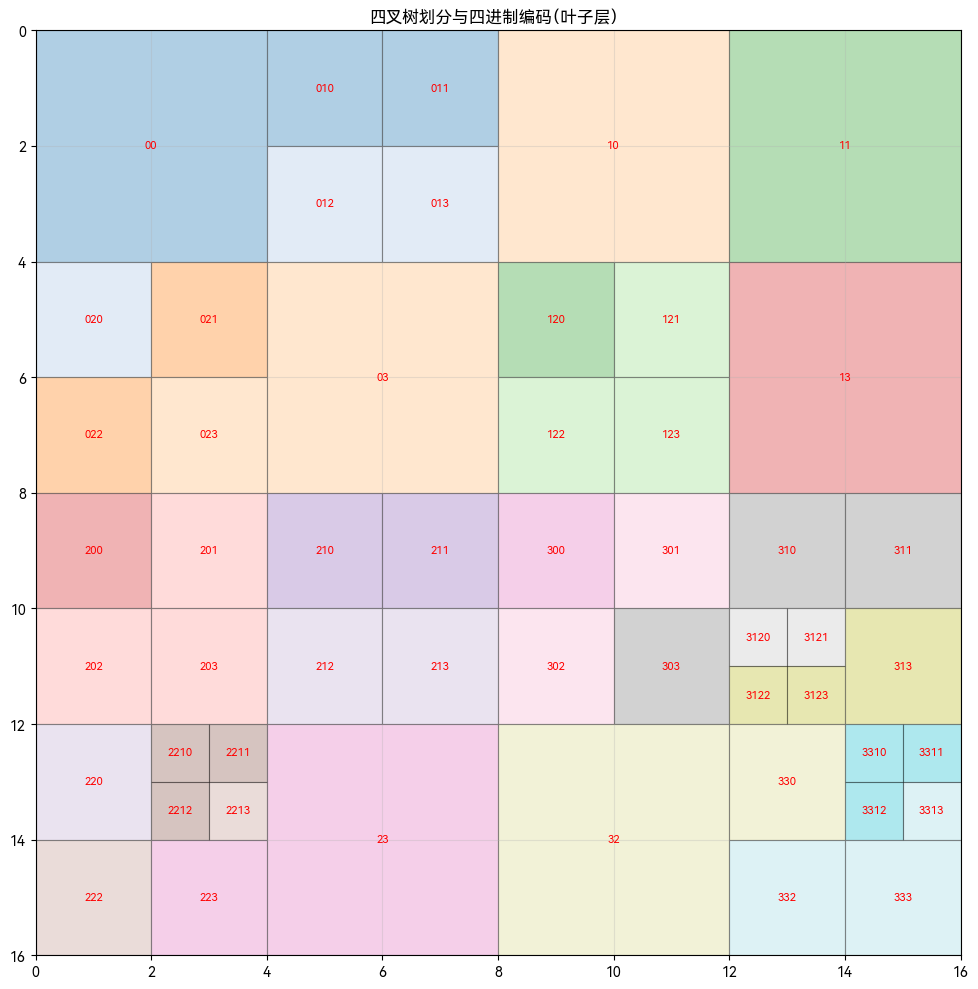

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# 可视化：绘制叶子矩形并标注四进制编码
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect('equal')
H, W = grid.shape
ax.set_xlim(0, W)
ax.set_ylim(0, H)
ax.invert_yaxis()  # 行号向下

n = len(leaves)
colors = cm.tab20(np.linspace(0, 1, max(n, 1)))

for i, lf in enumerate(leaves):
    r0, c0, r1, c1 = lf.r0, lf.c0, lf.r1, lf.c1
    # 绘制矩形边界
    ax.add_patch(plt.Rectangle((c0, r0), c1 - c0, r1 - r0,
                               fill=True, alpha=0.35,
                               edgecolor='black', linewidth=0.8,
                               facecolor=colors[i % len(colors)]))
    # 标注编码（四进制）
    cx = (c0 + c1) / 2
    cy = (r0 + r1) / 2
    ax.text(cx, cy, lf.code4 if lf.code4 != '' else '∅',
            color='red', fontsize=8, ha='center', va='center')

ax.set_title('四叉树划分与四进制编码（叶子层）')
ax.grid(True, alpha=0.3)
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['HarmonyOS Sans SC']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

plt.tight_layout()
plt.show()

In [3]:
# 查询示例：给定栅格位置返回编码-值映射
samples = [(0,0), (7,2), (12,14), (15,15)]
for (r, c) in samples:
    mapping = query_mapping(leaves, r, c)
    print(f"像素({r},{c}) -> 四进制: {mapping['code4']}, 莫顿码: {mapping['morton']}, 值: {mapping['value']}")

像素(0,0) -> 四进制: 00, 莫顿码: 0, 值: 1
像素(7,2) -> 四进制: 023, 莫顿码: 11, 值: 1
像素(12,14) -> 四进制: 3310, 莫顿码: 244, 值: 1
像素(15,15) -> 四进制: 333, 莫顿码: 63, 值: 2


## 算法说明与空间占用比较

- 算法（自上而下）：从整幅栅格开始，若块内值一致则生成叶子；否则按象限 0/1/2/3 递归分割，记录路径为四进制编码。莫顿码为按基数4解释后的十进制。
- 叶子列表含义：每个叶子记录其在原图的矩形范围 `(r0,c0,r1,c1)`、统一值 `value`、编码 `code4/morton`。
- 压缩思想：对于大面积一致的区域，用单个叶子描述，比逐像素存储更省空间。对示例数据，统计叶子数量与像素数量：叶子远小于 `H×W` 时即体现压缩。
- 空间占用对比：
  - 原始：`H×W` 个整数值。
  - 四进制码：存储每个叶子的 `code4` 字符串 + 值 + 块范围；十进制莫顿码可代替字符串以减少存储（整型）。
  - 实务上可仅存 `(r0,c0,r1,c1,value)` 或 `(morton,level,value)`，根据系统设计权衡。